In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import hstack
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
!pip install gradio


**Extract Images**

In [2]:
!apt-get install -y p7zip-full

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


In [3]:


MERGED_FOLDER = "/content/merged_imgs"
os.makedirs(MERGED_FOLDER, exist_ok=True)

# Extract ZIP files
for f in os.listdir("/content"):
    if f.endswith(".zip"):
        zip_path = os.path.join("/content", f)
        print(f"Extracting {zip_path} ...")
        os.system(f"unzip -q {zip_path} -d {MERGED_FOLDER}")

# Extract 7z files
for f in os.listdir("/content"):
    if f.endswith(".7z"):
        sevenz_path = os.path.join("/content", f)
        print(f"Extracting {sevenz_path} ...")
        os.system(f"7z x {sevenz_path} -o{MERGED_FOLDER} -y")

print("✅ All archives extracted to /content/merged_imgs")

Extracting /content/bones.zip ...
Extracting /content/neck.zip ...
Extracting /content/dental.zip ...
Extracting /content/chest.zip ...
Extracting /content/knee.zip ...
✅ All archives extracted to /content/merged_imgs


In [4]:
!ls /content/merged_imgs

bones  chest  dental  knee  neck


In [5]:


SOURCE = "/content/merged_imgs"
DEST = "/content/dataset"
os.makedirs(DEST, exist_ok=True)

for organ in os.listdir(SOURCE):
    organ_path = os.path.join(SOURCE, organ)
    if not os.path.isdir(organ_path):
        continue

    for label in os.listdir(organ_path):
        label_path = os.path.join(organ_path, label)
        if not os.path.isdir(label_path):
            continue

        class_name = f"{organ}_{label}"
        class_dir = os.path.join(DEST, class_name)
        os.makedirs(class_dir, exist_ok=True)

        for img in os.listdir(label_path):
            shutil.copy(os.path.join(label_path, img), os.path.join(class_dir, img))

print("✅ Dataset prepared for CNN")

✅ Dataset prepared for CNN


In [6]:

print("Folders in dataset:")
for cls in os.listdir(DEST):
    n = len(os.listdir(os.path.join(DEST, cls)))
    print(f"{cls}: {n} images")


Folders in dataset:
bones_Fractured: 780 images
knee_normal: 220 images
dental_normal: 223 images
chest_normal: 352 images
knee_not normal: 236 images
neck_normal: 71 images
chest_not normal: 554 images
dental_not normal: 173 images
neck_not normal: 267 images
bones_Non-Fractured: 1740 images


**Text preprocessing**

In [7]:
df = pd.read_csv("noisy_medical_data.csv")

df.head()
df.info()
df.isnull().sum()
df["Label"].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            500 non-null    int64 
 1   Opinion       500 non-null    object
 2   Source        500 non-null    object
 3   DiseaseLabel  500 non-null    object
 4   Label         500 non-null    object
dtypes: int64(1), object(4)
memory usage: 19.7+ KB


,count
Label,
Incorrect,258
Correct,242


In [8]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_Opinion"] = df["Opinion"].apply(clean_text)


In [9]:


X = df["clean_Opinion"]
y = df["Label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [10]:


tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    stop_words="english",
    max_features=5000
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


**LogisticRegression**

In [11]:


lr_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_lr))


              precision    recall  f1-score   support

     Correct       0.82      0.85      0.84        48
   Incorrect       0.86      0.83      0.84        52

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



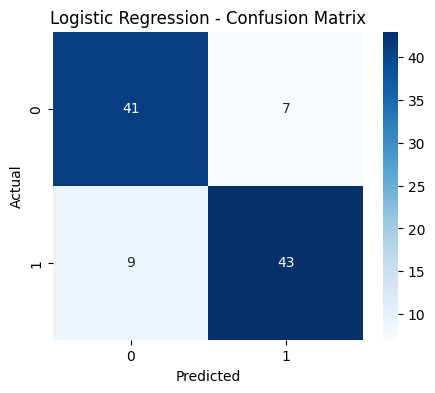

In [12]:
cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**SVM**

In [13]:

svm_model = SVC(kernel="linear", probability=True)

svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_svm))


              precision    recall  f1-score   support

     Correct       0.82      0.85      0.84        48
   Incorrect       0.86      0.83      0.84        52

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



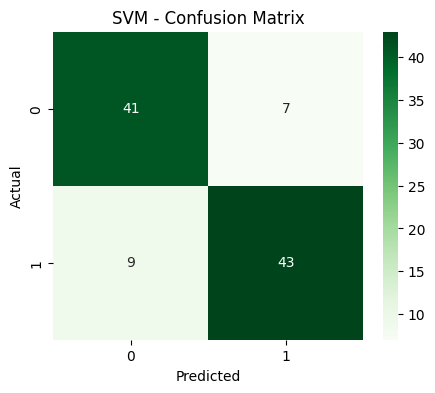

In [14]:
cm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("SVM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**Naive Bayes**

In [15]:


nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

y_pred_nb = nb_model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_nb))


              precision    recall  f1-score   support

     Correct       0.82      0.85      0.84        48
   Incorrect       0.86      0.83      0.84        52

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



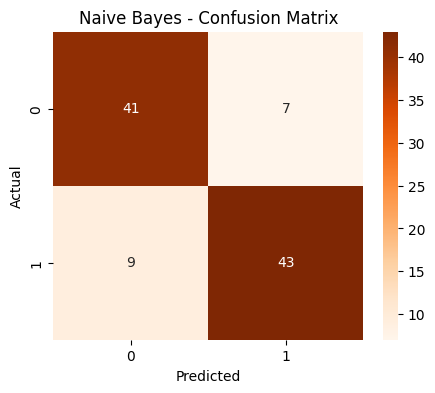

In [16]:
cm = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges")
plt.title("Naive Bayes - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**RandomForest**

In [17]:

source_encoder = LabelEncoder()
disease_encoder = LabelEncoder()
label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(df["Label"])

X_source = source_encoder.fit_transform(df["Source"]).reshape(-1,1)
X_disease = disease_encoder.fit_transform(df["DiseaseLabel"]).reshape(-1,1)

X_text_tfidf = tfidf.fit_transform(df["clean_Opinion"])

X_final = hstack([X_text_tfidf, X_source, X_disease])


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print(classification_report(
    y_test, y_pred_rf,
    target_names=label_encoder.classes_
))


              precision    recall  f1-score   support

     Correct       0.77      0.77      0.77        48
   Incorrect       0.79      0.79      0.79        52

    accuracy                           0.78       100
   macro avg       0.78      0.78      0.78       100
weighted avg       0.78      0.78      0.78       100



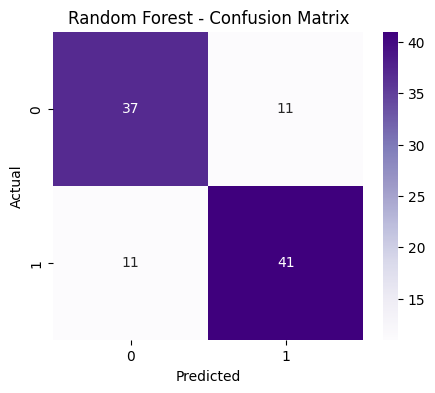

In [19]:
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**CNN**

In [20]:


print("Folders in dataset:")
for cls in os.listdir(DEST):
    n = len(os.listdir(os.path.join(DEST, cls)))
    print(f"{cls}: {n} images")

Folders in dataset:
bones_Fractured: 780 images
knee_normal: 220 images
dental_normal: 223 images
chest_normal: 352 images
knee_not normal: 236 images
neck_normal: 71 images
chest_not normal: 554 images
dental_not normal: 173 images
neck_not normal: 267 images
bones_Non-Fractured: 1740 images


In [21]:


SRC = DEST
TRAIN_DIR = "/content/train"
VAL_DIR = "/content/val"
VAL_SPLIT = 0.2  # 20% validation

os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(VAL_DIR, exist_ok=True)

for cls in os.listdir(SRC):
    class_path = os.path.join(SRC, cls)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(images)
    split_idx = int(len(images) * VAL_SPLIT)

    # Create class folders in train and val
    train_class_dir = os.path.join(TRAIN_DIR, cls)
    val_class_dir = os.path.join(VAL_DIR, cls)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)

    for i, img in enumerate(images):
        src_path = os.path.join(class_path, img)
        if i < split_idx:
            shutil.copy(src_path, os.path.join(val_class_dir, img))
        else:
            shutil.copy(src_path, os.path.join(train_class_dir, img))

print("✅ Train/Validation split done")

✅ Train/Validation split done


In [22]:

print("Train folder structure:")
for cls in os.listdir(TRAIN_DIR):
    n = len(os.listdir(os.path.join(TRAIN_DIR, cls)))
    print(f"{cls}: {n} images")

print("\nValidation folder structure:")
for cls in os.listdir(VAL_DIR):
    n = len(os.listdir(os.path.join(VAL_DIR, cls)))
    print(f"{cls}: {n} images")

Train folder structure:
bones_Fractured: 624 images
knee_normal: 176 images
dental_normal: 179 images
chest_normal: 282 images
knee_not normal: 189 images
neck_normal: 57 images
chest_not normal: 444 images
dental_not normal: 139 images
neck_not normal: 214 images
bones_Non-Fractured: 1392 images

Validation folder structure:
bones_Fractured: 156 images
knee_normal: 44 images
dental_normal: 44 images
chest_normal: 70 images
knee_not normal: 47 images
neck_normal: 14 images
chest_not normal: 110 images
dental_not normal: 34 images
neck_not normal: 53 images
bones_Non-Fractured: 348 images


In [23]:
IMG_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 10

train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    "/content/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_data = val_gen.flow_from_directory(
    "/content/val",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)


Found 3696 images belonging to 10 classes.
Found 920 images belonging to 10 classes.


In [24]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(train_data.num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 270ms/step - accuracy: 0.5409 - loss: 1.3402 - val_accuracy: 0.7065 - val_loss: 0.6502
Epoch 2/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 31s 266ms/step - accuracy: 0.7419 - loss: 0.5645 - val_accuracy: 0.7467 - val_loss: 0.5168
Epoch 3/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 31s 266ms/step - accuracy: 0.7920 - loss: 0.4262 - val_accuracy: 0.7598 - val_loss: 0.4475
Epoch 4/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 42s 274ms/step - accuracy: 0.8242 - loss: 0.3764 - val_accuracy: 0.7739 - val_loss: 0.4406
Epoch 5/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 30s 262ms/step - accuracy: 0.8485 - loss: 0.3214 - val_accuracy: 0.7772 - val_loss: 0.4264
Epoch 6/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 31s 266ms/step - accuracy: 0.8604 - loss: 0.2938 - val_accuracy: 0.7489 - val_loss: 0.5052
Epoch 7/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 31s 266ms/step - accuracy: 0.8818 - loss: 0.2558 - val_accuracy: 0.7804 - val_loss: 0.4870
Epoch 8/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 32s 272ms/step - accuracy: 0.9082 - loss: 0

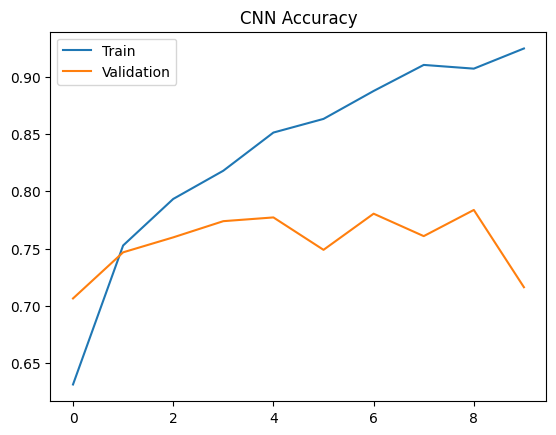

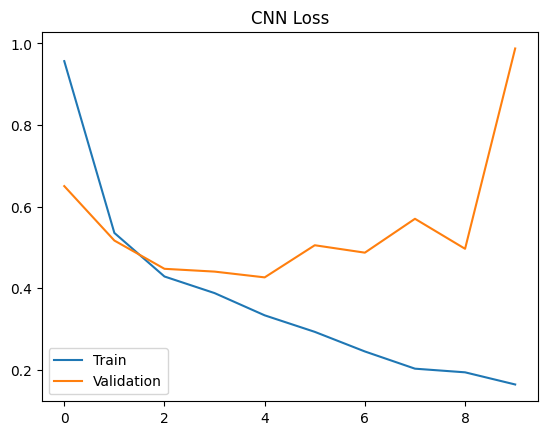

In [25]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS
)

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("CNN Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("CNN Loss")
plt.legend()
plt.show()


**TEST FOR CNN**

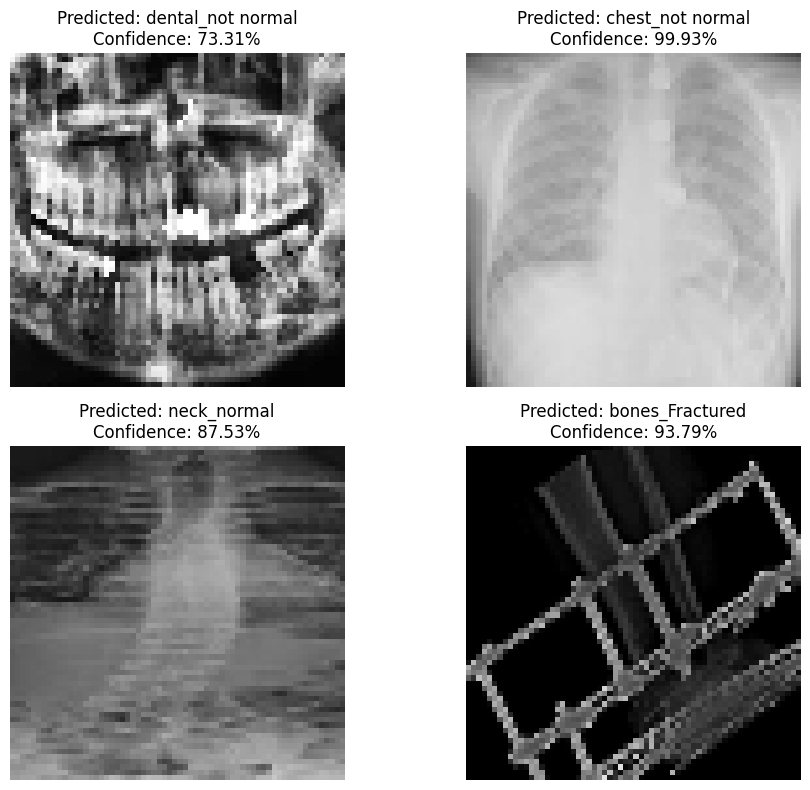

In [29]:


# 🔹 Put paths of 4 images here (change names if needed)
image_paths = [
    "/content/dataset/Test/11.jpg",
    "/content/dataset/Test/TB.107.jpg",
    "/content/dataset/Test/N17,N,M,19_1_0.jpg",
    "/content/dataset/Test/Fractured (101)_aug_1.jpg"
]

class_names = list(train_data.class_indices.keys())

plt.figure(figsize=(10,8))

for i, img_path in enumerate(image_paths):
    # Load & preprocess image
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    pred = model.predict(img_array, verbose=0)
    pred_class = np.argmax(pred, axis=1)[0]
    confidence = np.max(pred) * 100

    # Plot
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(
        f"Predicted: {class_names[pred_class]}\n"
        f"Confidence: {confidence:.2f}%"
    )

plt.tight_layout()
plt.show()


**Decision-Level Fusion**

In [26]:
# Logistic Regression probabilities on test text
lr_probs = lr_model.predict_proba(X_test_tfidf)

# Map label index
lr_classes = lr_model.classes_
print(lr_classes)


['Correct' 'Incorrect']


In [27]:
p_text_correct = lr_probs[:, list(lr_classes).index("Correct")]


In [28]:
cnn_probs = model.predict(val_data)


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step


In [29]:
class_names = list(train_data.class_indices.keys())

abnormal_indices = [
    i for i, name in enumerate(class_names)
    if ("not_normal" in name.lower()) or ("fractured" in name.lower())
]


In [30]:
p_image_abnormal = cnn_probs[:, abnormal_indices].sum(axis=1)
p_image_normal = 1 - p_image_abnormal


In [31]:
min_len = min(len(p_text_correct), len(p_image_abnormal))

p_text_correct = p_text_correct[:min_len]
p_image_abnormal = p_image_abnormal[:min_len]


In [32]:
alpha = 0.5  # text importance
beta = 0.5   # image importance


In [33]:
fusion_score = alpha * p_text_correct + beta * p_image_abnormal
fusion_pred = np.where(fusion_score >= 0.5, "Correct", "Incorrect")


In [34]:
fusion_df = pd.DataFrame({
    "Text_Prob_Correct": p_text_correct,
    "Image_Prob_Abnormal": p_image_abnormal,
    "Fusion_Score": fusion_score,
    "Fusion_Prediction": fusion_pred
})

fusion_df.head()


,Text_Prob_Correct,Image_Prob_Abnormal,Fusion_Score,Fusion_Prediction
0,0.216837,1.000000,0.608418,Correct
1,0.279626,0.999993,0.639809,Correct
2,0.606048,0.999992,0.803020,Correct
3,0.175185,0.001727,0.088456,Incorrect
4,0.814259,0.000008,0.407134,Incorrect


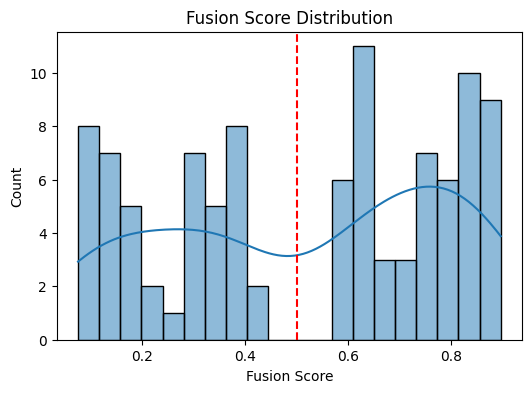

In [35]:
plt.figure(figsize=(6,4))
sns.histplot(fusion_score, bins=20, kde=True)
plt.axvline(0.5, color="red", linestyle="--")
plt.title("Fusion Score Distribution")
plt.xlabel("Fusion Score")
plt.show()


In [38]:
import gradio as gr
import numpy as np
import tensorflow as tf

def fusion_predict(text, image):
    # ------------------
    # TEXT MODEL (Logistic Regression)
    # ------------------
    text_vec = tfidf.transform([text])
    text_probs = lr_model.predict_proba(text_vec)[0]
    p_text_correct = text_probs[list(lr_model.classes_).index("Correct")]

    # ------------------
    # IMAGE MODEL (CNN)
    # ------------------
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    image = tf.expand_dims(image, axis=0)

    cnn_probs = model.predict(image)[0]
    p_image_abnormal = cnn_probs[abnormal_indices].sum()

    # ------------------
    # DECISION-LEVEL FUSION
    # ------------------
    alpha = 0.5
    beta = 0.5

    fusion_score = alpha * p_text_correct + beta * p_image_abnormal
    final_decision = "Correct" if fusion_score >= 0.5 else "Incorrect"

    return {
        "Text Probability (Correct)": float(p_text_correct),
        "Image Probability (Abnormal)": float(p_image_abnormal),
        "Fusion Score": float(fusion_score),
        "Final Decision": final_decision
    }


In [39]:
interface = gr.Interface(
    fn=fusion_predict,
    inputs=[
        gr.Textbox(lines=4, placeholder="Enter medical statement...", label="Medical Text"),
        gr.Image(type="numpy", label="X-ray Image")
    ],
    outputs=gr.JSON(label="Prediction Output"),
    title="Multimodal Misinformation Detection",
    description="This system combines text-based Logistic Regression and image-based CNN using decision-level fusion."
)

interface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://eeef87d0baef4020d6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
